In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

2025-11-21 22:45:11.866720: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 22:45:11.994287: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 22:45:12.860160: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import kagglehub
import os

dataset_path = kagglehub.dataset_download('bhavikjikadara/dog-and-cat-classification-dataset')
directory = os.path.join(dataset_path, 'PetImages')

In [3]:
images = []
labels = []

try:
  for foldr in os.listdir(directory):
    for filee in os.listdir(os.path.join(directory, foldr)):
      images.append(os.path.join(foldr, filee))
      labels.append(foldr)

except Exception as e:
  print(f'Error: {e}')

all_df = pd.DataFrame({
    'Images': images,
    'Labels': labels
    })

all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Images  24998 non-null  object
 1   Labels  24998 non-null  object
dtypes: object(2)
memory usage: 390.7+ KB


In [4]:
all_df.groupby("Labels").count()

,Images
Labels,
Cat,12499
Dog,12499


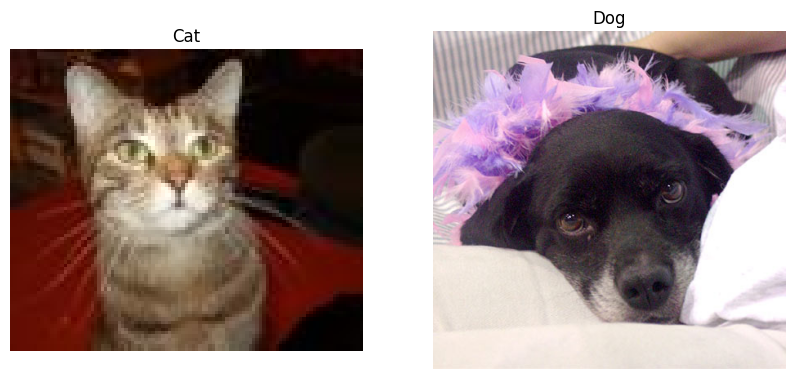

In [5]:
plt.figure(figsize=(10, 6))

for i, label in enumerate(all_df['Labels'].unique()):
    sample = all_df[all_df['Labels'] == label].sample(1).iloc[0]
    img_path = os.path.join(directory, sample['Images'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(all_df['Labels'].unique()), i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df, test_df = train_test_split(all_df, test_size=0.2, random_state=111620206, stratify=all_df['Labels'])

In [7]:
train_df_small = train_df.sample(n=100, random_state=42).reset_index(drop=True)

In [8]:
trainimgen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2
    )

train_data = trainimgen.flow_from_dataframe(
    dataframe=train_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
)




Found 19998 validated image filenames belonging to 2 classes.


In [9]:
testimgen = ImageDataGenerator()

test_data = testimgen.flow_from_dataframe(
    dataframe=test_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
    shuffle=False # For test data, it's crucial to set shuffle=False. This ensures the prediction order matches the label order, which is necessary for correct evaluation with metrics like a confusion matrix.
)

Found 5000 validated image filenames belonging to 2 classes.


## Model Time

In [10]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_std=1.0):
        super(BayesianLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.prior_std = prior_std

        # Initialize mu with Xavier initialization
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        nn.init.xavier_normal_(self.weight_mu)
        
        self.bias_mu = nn.Parameter(torch.zeros(out_features))

        # Initialize rho to give initial std = 0.1
        # softplus(rho) = std, so rho = softplus_inv(std)
        # softplus_inv(x) ≈ log(exp(x) - 1) for x > 0
        # For small x: softplus_inv(x) ≈ log(x)
        # initial_std = 0.1
        initial_std = prior_std
        initial_rho = torch.log(torch.tensor(initial_std))
        
        self.weight_rho = nn.Parameter(torch.ones_like(self.weight_mu) * initial_rho)
        self.bias_rho = nn.Parameter(torch.ones_like(self.bias_mu) * initial_rho)

    def forward(self, x):
        weight_std = F.softplus(self.weight_rho)
        weight = self.weight_mu + weight_std * torch.randn_like(self.weight_mu)

        bias_std = F.softplus(self.bias_rho)
        bias = self.bias_mu + bias_std * torch.randn_like(self.bias_mu)

        return F.linear(x, weight, bias)

    def kl_divergence(self):
        weight_std = F.softplus(self.weight_rho)
        bias_std = F.softplus(self.bias_rho)

        # KL between N(mu, std) and N(0, prior_std)
        kl_weight = self._kl_normal(self.weight_mu, weight_std, self.prior_std)
        kl_bias = self._kl_normal(self.bias_mu, bias_std, self.prior_std)
        
        return kl_weight + kl_bias

    def _kl_normal(self, mu, std, prior_std):
        prior_var = prior_std ** 2
        var = std ** 2
        
        kl = 0.5 * (torch.log(prior_var / var) + (var + mu**2) / prior_var - 1)
        return kl.sum()


class BayesianConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1, prior_std=1.0):
        super(BayesianConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.stride = stride
        self.prior_std = prior_std

        # Initialize with Kaiming (He) initialization for conv layers
        self.weight_mu = nn.Parameter(torch.Tensor(
            out_channels, in_channels, *self.kernel_size))
        nn.init.kaiming_normal_(self.weight_mu, mode='fan_out', nonlinearity='relu')
        
        self.bias_mu = nn.Parameter(torch.zeros(out_channels))

        # Initialize rho for initial std = 0.05 (smaller for conv layers)
        # initial_std = 0.05
        initial_std = prior_std
        initial_rho = torch.log(torch.tensor(initial_std))
        
        self.weight_rho = nn.Parameter(torch.ones_like(self.weight_mu) * initial_rho)
        self.bias_rho = nn.Parameter(torch.ones_like(self.bias_mu) * initial_rho)

    def forward(self, x):
        weight_std = F.softplus(self.weight_rho)
        weight = self.weight_mu + weight_std * torch.randn_like(self.weight_mu)

        bias_std = F.softplus(self.bias_rho)
        bias = self.bias_mu + bias_std * torch.randn_like(self.bias_mu)

        return F.conv2d(x, weight, bias, stride=self.stride, padding=self.padding)

    def kl_divergence(self):
        weight_std = F.softplus(self.weight_rho)
        bias_std = F.softplus(self.bias_rho)

        kl_weight = self._kl_normal(self.weight_mu, weight_std, self.prior_std)
        kl_bias = self._kl_normal(self.bias_mu, bias_std, self.prior_std)
        
        return kl_weight + kl_bias

    def _kl_normal(self, mu, std, prior_std):
        prior_var = prior_std ** 2
        var = std ** 2
        
        kl = 0.5 * (torch.log(prior_var / var) + (var + mu**2) / prior_var - 1)
        return kl.sum()


class BayesianCNN(nn.Module):
    def __init__(self):
        super(BayesianCNN, self).__init__()

        # Use larger prior std for early layers, smaller for later layers
        self.conv1 = BayesianConv2d(3, 16, kernel_size=3, padding=1, prior_std=0.3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BayesianConv2d(16, 32, kernel_size=3, padding=1, prior_std=0.2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = BayesianConv2d(32, 64, kernel_size=3, padding=1, prior_std=0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = BayesianLinear(28*28*64, 128, prior_std=0.1)
        self.fc2 = BayesianLinear(128, 2, prior_std=0.1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def kl_divergence(self):
        # Total KL divergence for the network
        kl = 0
        kl += self.conv1.kl_divergence()
        kl += self.conv2.kl_divergence()
        kl += self.conv3.kl_divergence()
        kl += self.fc1.kl_divergence()
        kl += self.fc2.kl_divergence()
        return kl

    def predict_with_uncertainty(self, x, num_samples=100):
        self.train()  # Keep in train mode to sample weights
        predictions = []

        with torch.no_grad():
            for _ in range(num_samples):
                output = self(x)
                probs = F.softmax(output, dim=1)
                predictions.append(probs)

        predictions = torch.stack(predictions)  # [num_samples, batch_size, num_classes]

        mean_predictions = predictions.mean(dim=0)
        std_predictions = predictions.std(dim=0)

        return mean_predictions, std_predictions, predictions

class ParameterTracker:
    # Track specific parameters during training
    def __init__(self, model, num_params_to_track=10):
        self.history = {
            'conv1_weight_mu': [],
            'conv1_weight_sigma': [],
            'fc1_weight_mu': [],
            'fc1_weight_sigma': [],
            'fc2_bias_mu': [],
            'fc2_bias_sigma': [],
        }

        # Randomly select indices to track
        conv1_size = model.conv1.weight_mu.numel()
        fc1_size = model.fc1.weight_mu.numel()
        fc2_bias_size = model.fc2.bias_mu.numel()

        self.indices = {
            'conv1': np.random.choice(conv1_size, num_params_to_track, replace=False),
            'fc1': np.random.choice(fc1_size, num_params_to_track, replace=False),
            'fc2_bias': np.random.choice(fc2_bias_size, min(num_params_to_track, fc2_bias_size), replace=False),
        }

    def record(self, model):
        # Conv1 weights
        weight_mu = model.conv1.weight_mu.detach().cpu().flatten().numpy()
        weight_rho = model.conv1.weight_rho.detach().cpu().flatten().numpy()
        weight_sigma = np.log1p(np.exp(weight_rho))
        self.history['conv1_weight_mu'].append(weight_mu[self.indices['conv1']])
        self.history['conv1_weight_sigma'].append(weight_sigma[self.indices['conv1']])

        # FC1 weights
        weight_mu = model.fc1.weight_mu.detach().cpu().flatten().numpy()
        weight_rho = model.fc1.weight_rho.detach().cpu().flatten().numpy()
        weight_sigma = np.log1p(np.exp(weight_rho))
        self.history['fc1_weight_mu'].append(weight_mu[self.indices['fc1']])
        self.history['fc1_weight_sigma'].append(weight_sigma[self.indices['fc1']])

        # FC2 biases
        bias_mu = model.fc2.bias_mu.detach().cpu().numpy()
        bias_rho = model.fc2.bias_rho.detach().cpu().numpy()
        bias_sigma = np.log1p(np.exp(bias_rho))
        self.history['fc2_bias_mu'].append(bias_mu[self.indices['fc2_bias']])
        self.history['fc2_bias_sigma'].append(bias_sigma[self.indices['fc2_bias']])

    def plot_evolution(self):
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        fig.suptitle('Parameter Evolution During Training', fontsize=16)

        epochs = np.arange(len(self.history['conv1_weight_mu']))

        # Conv1 weight mu
        for i in range(len(self.indices['conv1'])):
            mu_values = [epoch_vals[i] for epoch_vals in self.history['conv1_weight_mu']]
            axes[0, 0].plot(epochs, mu_values, alpha=0.7, label=f'Weight {i}')
        axes[0, 0].set_title('Conv1 Weight μ Evolution')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('μ value')
        axes[0, 0].grid(alpha=0.3)

        # Conv1 weight sigma
        for i in range(len(self.indices['conv1'])):
            sigma_values = [epoch_vals[i] for epoch_vals in self.history['conv1_weight_sigma']]
            axes[0, 1].plot(epochs, sigma_values, alpha=0.7, label=f'Weight {i}')
        axes[0, 1].set_title('Conv1 Weight σ Evolution')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('σ value')
        axes[0, 1].grid(alpha=0.3)

        # FC1 weight mu
        for i in range(len(self.indices['fc1'])):
            mu_values = [epoch_vals[i] for epoch_vals in self.history['fc1_weight_mu']]
            axes[1, 0].plot(epochs, mu_values, alpha=0.7)
        axes[1, 0].set_title('FC1 Weight μ Evolution')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('μ value')
        axes[1, 0].grid(alpha=0.3)

        # FC1 weight sigma
        for i in range(len(self.indices['fc1'])):
            sigma_values = [epoch_vals[i] for epoch_vals in self.history['fc1_weight_sigma']]
            axes[1, 1].plot(epochs, sigma_values, alpha=0.7)
        axes[1, 1].set_title('FC1 Weight σ Evolution')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('σ value')
        axes[1, 1].grid(alpha=0.3)

        # FC2 bias mu
        for i in range(len(self.indices['fc2_bias'])):
            mu_values = [epoch_vals[i] for epoch_vals in self.history['fc2_bias_mu']]
            axes[2, 0].plot(epochs, mu_values, alpha=0.7, marker='o', markersize=3)
        axes[2, 0].set_title('FC2 Bias μ Evolution')
        axes[2, 0].set_xlabel('Epoch')
        axes[2, 0].set_ylabel('μ value')
        axes[2, 0].grid(alpha=0.3)

        # FC2 bias sigma
        for i in range(len(self.indices['fc2_bias'])):
            sigma_values = [epoch_vals[i] for epoch_vals in self.history['fc2_bias_sigma']]
            axes[2, 1].plot(epochs, sigma_values, alpha=0.7, marker='o', markersize=3)
        axes[2, 1].set_title('FC2 Bias σ Evolution')
        axes[2, 1].set_xlabel('Epoch')
        axes[2, 1].set_ylabel('σ value')
        axes[2, 1].axhline(1, color='red', linestyle='--', alpha=0.5, label='Prior σ=1')
        axes[2, 1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BayesianCNN().to(device)
model

Using device: cuda


BayesianCNN(
  (conv1): BayesianConv2d()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BayesianConv2d()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): BayesianConv2d()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): BayesianLinear()
  (fc2): BayesianLinear()
)

In [12]:
print(f"train_data will have {len(train_data)} batches")

train_data will have 1250 batches


In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

save_dir = '../models/'

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tracker = ParameterTracker(model, num_params_to_track=10)
tracker.record(model)

# Calculate beta based on total number of training samples
beta = 1.0 / (len(train_df) * 10) 
print(f"Beta: {beta:.8f}")

num_epochs = 50
num_batches = len(train_data)
train_losses = []
val_accuracies = []

# Early stopping parameters
best_val_accuracy = 0.0
patience = 5  # Number of epochs to wait for improvement
patience_counter = 0

for epoch in range(num_epochs):
    model.train()

    total_loss = 0
    total_nll = 0
    total_kl = 0

    for batch_idx, (data, target) in enumerate(train_data):
        if batch_idx >= num_batches:
            break

        # Convert numpy arrays to PyTorch tensors
        data = torch.FloatTensor(data).to(device)
        target = torch.LongTensor(target.astype(int)).to(device)

        # Normalize pixel values to [0, 1] if not already done
        if data.max() > 1.0:
            data = data / 255.0

        # Transpose from (batch, height, width, channels) to (batch, channels, height, width)
        data = data.permute(0, 3, 1, 2)

        # Forward pass
        output = model(data)
        nll_loss = F.cross_entropy(output, target)
        kl_loss = model.kl_divergence()
        loss = nll_loss + beta * kl_loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_nll += nll_loss.item()
        total_kl += kl_loss.item()

    avg_loss = total_loss / len(train_data)
    avg_nll = total_nll / len(train_data)
    avg_kl = total_kl / len(train_data)
    train_losses.append(avg_loss)

    tracker.record(model)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Loss: {avg_loss:.4f} (NLL: {avg_nll:.4f}, KL: {avg_kl:.4f})')

    # ============ VALIDATION ACCURACY ============
    # Calculate validation accuracy every 2 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_data):
                if batch_idx >= len(test_data):
                    break

                # Convert to tensors
                data = torch.FloatTensor(data).to(device)
                target = torch.LongTensor(target.astype(int)).to(device)

                # Normalize
                if data.max() > 1.0:
                    data = data / 255.0

                # Transpose
                data = data.permute(0, 3, 1, 2)

                # Forward pass (single sample for speed)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)

                total += target.size(0)
                correct += (predicted == target).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f'  Validation Accuracy: {val_accuracy:.2f}%')

        # Early stopping check
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_accuracies': val_accuracies,
                'best_val_accuracy': best_val_accuracy,
            }, f'{save_dir}/best_bayesian_cnn_catdog.pth')
            print(f'  ✓ New best model saved! (Val Acc: {val_accuracy:.2f}%)')
        else:
            patience_counter += 1
            print(f'  No improvement. Patience: {patience_counter}/{patience}')

            if patience_counter >= patience:
                print(f'\nEarly stopping triggered at epoch {epoch+1}')
                print(f'Best validation accuracy: {best_val_accuracy:.2f}%')
                break

    # Save periodic checkpoints every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
        }, f'{save_dir}/bayes_checkpoint_epoch_{epoch+1}.pth')
        print(f"Checkpoint saved at epoch {epoch+1}")


# Save the final model
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_accuracies': val_accuracies,
    'tracker_history': tracker.history,
    'best_val_accuracy': best_val_accuracy,
}, f'{save_dir}/bayes_cnn_catdog_final.pth')

print(f"\nTraining completed!")
print(f"Final model saved as 'bayesian_cnn_catdog_final.pth'")
print(f"Best model saved as 'best_bayesian_cnn_catdog.pth'")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")

Beta: 0.00000500


/home/leen2/Documents/stat340_bayesian_cnns/env/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/50:
  Loss: 3.9813 (NLL: 3.7424, KL: 47769.4982)
Epoch 2/50:
  Loss: 0.9274 (NLL: 0.7111, KL: 43258.0839)
  Validation Accuracy: 50.58%
  ✓ New best model saved! (Val Acc: 50.58%)
Epoch 3/50:
  Loss: 0.8854 (NLL: 0.7124, KL: 34584.5400)
Epoch 4/50:
  Loss: 0.8703 (NLL: 0.7101, KL: 32027.2489)
  Validation Accuracy: 50.60%
  ✓ New best model saved! (Val Acc: 50.60%)
Epoch 5/50:
  Loss: 0.8560 (NLL: 0.7117, KL: 28865.5763)
Checkpoint saved at epoch 5
Epoch 6/50:
  Loss: 0.8420 (NLL: 0.7091, KL: 26567.6364)
  Validation Accuracy: 49.32%
  No improvement. Patience: 1/5
Epoch 7/50:
  Loss: 0.8195 (NLL: 0.7118, KL: 21544.5846)
Epoch 8/50:
  Loss: 0.7723 (NLL: 0.6997, KL: 14516.1392)
  Validation Accuracy: 50.46%
  No improvement. Patience: 2/5
Epoch 9/50:
  Loss: 0.7652 (NLL: 0.7043, KL: 12175.1774)
Epoch 10/50:
  Loss: 0.7641 (NLL: 0.7039, KL: 12041.3813)
  Validation Accuracy: 50.32%
  No improvement. Patience: 3/5
Checkpoint saved at epoch 10
Epoch 11/50:
  Loss: 0.7579 (NLL: 0.70

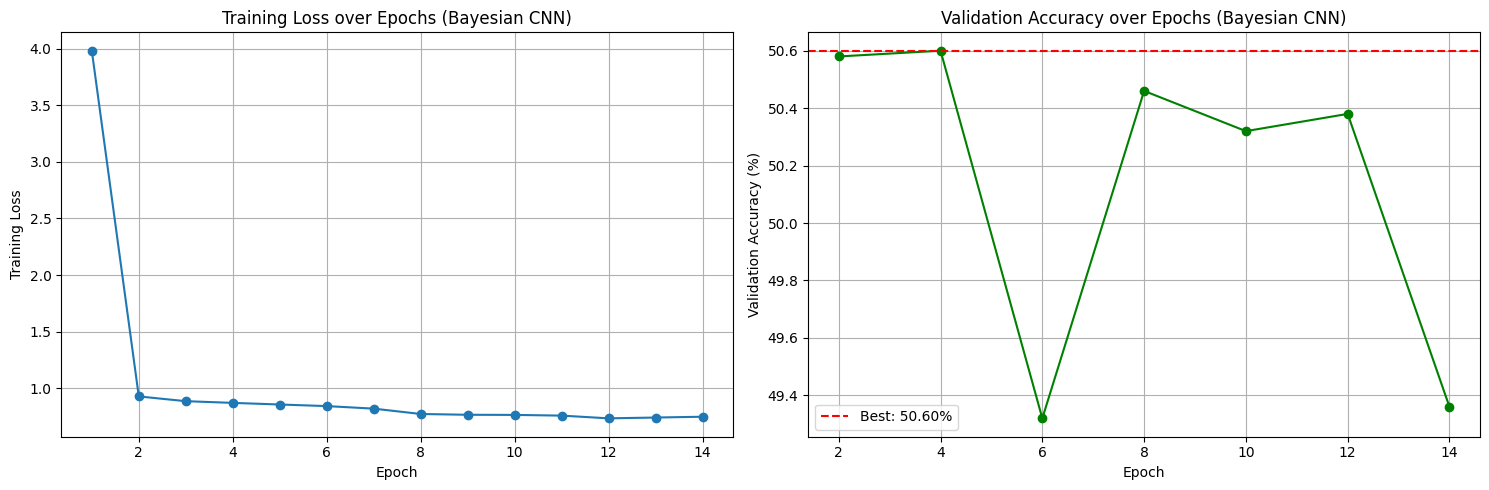


Final Training Loss: 0.7480
Final Validation Accuracy: 49.36%


In [15]:
# Plot training loss and validation accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss
ax1.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss over Epochs (Bayesian CNN)')
ax1.grid(True)

# Plot validation accuracy
val_epochs = list(range(2, 2 * len(val_accuracies) + 1, 2))
ax2.plot(val_epochs, val_accuracies, marker='o', color='green')
ax2.axhline(y=best_val_accuracy, color='r', linestyle='--', label=f'Best: {best_val_accuracy:.2f}%')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('Validation Accuracy over Epochs (Bayesian CNN)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
if len(val_accuracies) > 0:
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BayesianCNN().to(device)
model.load_state_dict(torch.load(f'{save_dir}checkpoint_epoch_10.pth'))
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: '../models/checkpoint_epoch_10.pth'